# ML with Large Datasets
----
## Dataset Description
In order to explore these Spark API, we use the [following dataset](). The data is from a population and housing census of some country ```X```  not identified for privacy reasons although this data is a very small subset of the actual data. 
Each row in the data represent a single individual in the population. 
 A summary of column description is provided below:
- **Geographic identifiers:** PROVINCE, REGION, DISTRICT, COMMUNE,MILIEU ,
       IDMEN, IDINDIV. This type of data has a somewhat hierarchical structure. We have a household (think of it as family), IDMEN-household ID. Within each household, we have individuals, IDINDIV - individual
       > 
- **MILIEU:** A classification of whether this person lived in urban or rural area. ```2-Rural, 1-Urban```
- **Sex**. ```P05```==>[1	- Male 2	- Female]
- **P19 Languages spoken**. What languages the person can speak.This variable is split into 4 variables as follows: ```P19MG, P19FR, P19AN, P19AU``` for local language, English, French and any other language.
- **P20, Literacy**. Whether the person can read and write any of the 3 languages given. Note that there three variables each representing each language. A local language, French and English. For each language, the value 1 means they can read and write in the language while 2 means they cannot.The variables are ```P20MG (local language), P20FR (French), P20AN (English), P20AU (other)```. 
- **P03:** whether the person is the head of the household, wife. child etc==>[0- Chef de Ménage (CM) 1- Conjoint(e) (CJ) 2-	Fils/Fille3-	Père/Mère 4-	Beau-Père/Belle-Mère 5-	Beau-Fils/Belle-Fille 6-	Petit fils/Petite-fille
 Autre Proche du CM 8- Autre proche du CJ 9 -Sans lien de parenté]

- **Age:**. Person's date of birth is given by column ```P07M``` (month of birth), ```P07A``` (year of birth) and ```P08``` (age)
- **Marital status:** ```P28``` (whether the person is married or not)==>[1-	Célibataire, 2-	Marié(e), 3-	Divorcé(e)/Séparé(e), 4-	Veuf(ve)]. This question is asked to residents who are 12 years or older. 
- **Age at first marriage**. ```P29``` (age at marriage).The question was like this: How old was <NAME> when he/she got married for the first time?
- **School attendance:** ```P21``` ==>[0 N'a Jamais fréquenté 1-A	fréquenté 2- Fréquente actuellement]
- **Highest school level attended:**```P22N```. This variable represents highest level of school attended. The question was asked like this: What is the highest level of education that (name) achieved during his studies?
 > 1. Preschool; 2. Primary-school; 3. Secondary; 4. Technical college; 5. University 
 - **Number of years of school completed at a particular level:** ```P22C``` Years completed at that level. A value of 0 means the person didnt complete the first year of education at that level. 
 > Preschool(0-2); Primary-school(0-5);Secondary(0-7); Technical college (0-7); University (0-7)
 
- **Whether the person worked or not:** ```P23```==> [1-	0ccupé 2-	Chômeur 3-	En quête du 1er emploi 4-	Ménagère 5-	Elève/Etudiant 6-	Retraité 7- lncapacité à travailler 8- Autre]

## The Task
The Ministry of Health in the country has expressed concern about the prevalence of early marriages among young individuals (both men and women). They have tasked you with investigating the factors contributing to early marriages. For the purpose of this analysis, individuals who get married at the age of 18 or younger are classified as having married early or belonging to the early marriage category. Beyond conducting exploratory analysis, the Ministry has requested that you develop a model to predict whether a person is likely to marry young, based on factors such as place of residence, household size, parents' education levels, and other relevant variables. In summary, these are the project goals.
1. Perfom explotaory analysis to understand early marriages 
2. Build a Machine Learning model which can predict whether a person will get married early or not.
3. Report on the model performance and efficacy

## Python setup

In [1]:
from datetime import datetime
from IPython.display import Image
import pandas as pd
# Suppress scientific notation globally
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
from pathlib import Path
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF, GradientBoostingClassifier as GBM, ExtraTreesClassifier as ETC, AdaBoostClassifier as Ada
from sklearn.metrics import accuracy_score, classification_report, accuracy_score
from tabulate import tabulate
import matplotlib.pyplot as plt

/home/emmmanuel/.local/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Inputs Paths, Global Variables and Parameters
Lets provide paths to input files we will use. 
Its a good practice to create these as global variables. Also, use Python module ```Path``` from pathlib to manage file paths. 

In [2]:
# Inputs Paths, Global Variables and Parameters
# path to hh_data.txt
HH_DATA = "/home/emmmanuel/Downloads/BDA_mini/ResidentIBEIPM.csv"

# Decide which columns to keep
COLS_TO_KEEP = [
    'PROVINCE', 'REGION', 'DISTRICT', 'COMMUNE', 'MILIEU', 'IDMEN', 'IDINDIV',
    'P05',  # Sex
    'P19MG', 'P19FR', 'P19AN', 'P19AU',  # Languages spoken
    'P20MG', 'P20FR', 'P20AN', 'P20AU',  # Literacy
    'P03',  # Household head status
    'P07M', 'P07A', 'P08',  # Age related
    'P28',  # Marital status
    'P29',  # Age at first marriage
    'P21',  # School attendance
    'P22N', 'P22C',  # School level
    'P23'  # Work status
]

# Regular household size threshold
# use quintiles to determine the threshold
HH_SIZE_THRESHOLD = 0.99

# CHILFREN AGE THRESHOLD
CHILDREN_AGE_THRESHOLD = 15
ELDERY_AGE_THRESHOLD = 65
EARLY_MARRIAGE_AGE_THRESHOLD = 18

In [4]:
spark = SparkSession.builder \
    .appName("LargeDatasetProcessing") \
    .master("local[8]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.memory.offHeap.enabled", "false") \
    .config("spark.sql.shuffle.partitions", "40") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC") \
    .config("spark.driver.extraJavaOptions", "-XX:+UseG1GC") \
    .getOrCreate()

# Preprocess the Data

The objective here is to load the dataset, retain only the necessary columns to reduce its size, and enable faster processing. During preprocessing, we aim to clean up the columns and convert numeric columns into proper numeric data types.

## Load the Data

I use Spark for loading the data because it is faster than pandas. Alternatively, students can use the pandas "chunk" method to load data in manageable chunks. Another approach is to first load a small sample of the dataset, identify and document the required columns, and then load only those columns from the full dataset.

## Subset the Columns

Whether or not all columns were initially loaded, this step involves selecting only the required columns for further processing.

## Preprocess and Clean Data

For columns such as `age`, ensure they are in numeric format. Rows containing invalid or erroneous data can be removed as part of the cleaning process.


# Task-1-Loading and subsetting data

## Provide your strategy/plan for efficiently loading the data

To manage the 16GB dataset, I initially used Spark to load the full dataset. Immediately, I selected only the essential columns – including demographics, education, and marital status – drastically reducing its size. I then wrote this subsetted data to a CSV file, partitioned to avoid single large files. Next, I transitioned to pandas, where I read the smaller CSV and performed the bulk of the data wrangling. I renamed columns, converted numeric columns, and used a custom function to engineer household size and dependent variables. After that, I cleaned missing data by using the mode for categorical and median for numeric columns. I also handled outliers for household size, children, and the elderly. I one-hot encoded categorical columns in preparation for machine learning algorithms. Finally, for modelling, I trained models using both scikit-learn and spark. I normalized my data before using the models.

In [5]:
sdf = spark.read.csv(HH_DATA, header=True, sep=",", inferSchema=True)

## Subset the Data
Keep only the columns we need and save a smaller dataset.

In [6]:
sdf2 = sdf.select(COLS_TO_KEEP)

In [7]:
out_csv = "/home/emmmanuel/Downloads/BDA_mini/output/proj-dataset-small"
sdf2.repartition(10).coalesce(1).write.csv(out_csv, header=True, sep=",", mode="overwrite")


In [8]:
sdf2.show(5)

+--------+------+--------+-------+------+--------------------+--------------------+---+-----+-----+-----+-----+-----+-----+-----+-----+---+----+----+---+---+---+---+----+----+---+
|PROVINCE|REGION|DISTRICT|COMMUNE|MILIEU|               IDMEN|             IDINDIV|P05|P19MG|P19FR|P19AN|P19AU|P20MG|P20FR|P20AN|P20AU|P03|P07M|P07A|P08|P28|P29|P21|P22N|P22C|P23|
+--------+------+--------+-------+------+--------------------+--------------------+---+-----+-----+-----+-----+-----+-----+-----+-----+---+----+----+---+---+---+---+----+----+---+
|       1|    11|     111|  11101|     1|11101101010011066...|11101101010010166...|  1|    1|    1|    2|    2|    1|    1|    2|    2|  0|  10|1954| 63|  2| 24|  1|   3|   7|  6|
|       1|    11|     111|  11101|     1|11101101010011066...|11101101010010166...|  2|    1|    1|    2|    2|    1|    1|    2|    2|  1|   8|1950| 67|  2| 28|  1|   3|   7|  6|
|       1|    11|     111|  11101|     1|11101101010011066...|11101101010010166...|  1|    1|    1| 

# Task-2

## Provide an explanation with a summary of data preprocessing steps you will apply to the data to end up with a dataset you need for building a model. 

My data preprocessing pipeline aimed to transform the raw census data into a clean, structured, and feature-rich dataset suitable for machine learning. First, after loading only the relevant columns using Spark, I read the smaller dataset into pandas for manipulation. I began with data cleaning, renaming columns for clarity and converting numeric columns to the correct data type using a custom convert2int function. This included handling cases where numbers were not interpretable by representing them with NaN values, and then removing these from the numeric columns. Then, I performed feature engineering, creating new household-level features using a custom gen_var_hh_size function, which generates the hh_size, num_children and num_elderly columns. I also created hoh_* variables, such as head-of-household age, education level, and literacy.

Further, I handled missing values by filling them with the mode for categorical features and the median for numerical features. I then addressed outliers, dropping rows with excessively large household sizes, and numbers of children and elderly. Crucially, I created my target variable, early_marriage, based on whether the marriage age was under 18 years. Finally, I one-hot encoded all categorical features, ensuring they can be used as input for the models. I also dropped the individual and household id variables. The output of all of these steps was a dataset with purely numeric features, which was ready for modeling.

## Data Preprocessing
- Rename columns for easy identification
- Perform data type conversion if necessary

In [10]:
# ==========================================================
# Load the smaller CSV fwe just created as pandas DataFrame
# ==========================================================
df = pd.read_csv("/home/emmmanuel/Downloads/BDA_mini/output/proj-dataset-small/part-00000-cb47f5d3-ddce-46a1-9580-fdfc931c4b03-c000.csv")

In [11]:
# ====================================
# RENAME COLUMNS
# ====================================
# Rename the columns to more meaningful names for easy understanding and ide
df.rename(columns={
    'PROVINCE': 'province',
    'REGION': 'region',
    'DISTRICT': 'district',
    'COMMUNE': 'commune',
    'MILIEU': 'milieu',
    'IDMEN': 'hh_id',
    'IDINDIV': 'indiv_id',
    'P05': 'sex',
    'P19MG': 'lang_local',
    'P19FR': 'lang_french',
    'P19AN': 'lang_english',
    'P19AU': 'lang_other',
    'P20MG': 'literacy_local',
    'P20FR': 'literacy_french',
    'P20AN': 'literacy_english',
    'P20AU': 'literacy_other',
    'P03': 'hh_relation',
    'P07M': 'birth_month',
    'P07A': 'birth_year',
    'P08': 'age',
    'P28': 'marital_status',
    'P29': 'age_married',
    'P21': 'school_attendance',
    'P22N': 'highest_school_level',
    'P22C': 'years_at_school_level',
    'P23': 'work_status'
}, inplace=True)

### Add New Variables We Need

In some cases, key information we need to explore may not be readily available in the dataset. For example, to analyze households, we might need to create a new column to represent household size.

#### Household Size
Household size refers to the number of people in a household. The dataset provides a household identifier (`hh_id`) and an individual identifier (`indiv_id`). Using these, we can generate a new column called `household_size`.

#### Feature Engineering: Creating Additional Variables
Feature engineering is the process of transforming raw data into meaningful features that improve the performance of machine learning models. This involves selecting, creating, modifying, or aggregating data attributes to make them more informative and relevant to the task at hand. Feature engineering is inherently a creative task—there are no strict rules. As a data scientist or machine learning practitioner, it's up to you to explore the data, consult domain experts, and study relevant literature to design and test new features.

For this analysis, we can consider creating the following features, which may influence the age at first marriage:

- **Number of dependent children in the household**: Defined as the number of individuals aged 15 and younger.
- **Number of dependent adults in the household**: Defined as the number of individuals aged 65 and older.

#### Household Level Variables 
Note that we have two levels of analysis units here: the individual and the household. As such, variables such as household size, number of children, number of the eldery are all household level variables. Since the head of the family or head of the household has more power in determing what happens in the house, we can also add household head variables. Concretely, for each household, we can have variables named like this: hoh_age, hoh_educ, hoh_literacy etc.

In [12]:
def gen_var_hh_size(df, hh_id_col='hh_id'):
    """Generates variable hh_size

    _extended_summary_

    Parameters
    ----------
    df : _type_
        _description_
    hh_id_col : str, optional
        _description_, by default 'hh_id'
    
    Returns
    -------
    _type_
        _description_
    """

    # ======================================================
    # GENERATE HH SIZE
    # ======================================================
    df_hhsize = df.groupby(hh_id_col).size().reset_index(name='hh_size')

    # Add index for easieer merging later
    df_hhsize.set_index(hh_id_col, inplace=True)

    # ======================================================
    # GENERATE NUMBER OF CHILDREN AND ELDERLY
    # ======================================================
    df_children = df[df['age'] <= CHILDREN_AGE_THRESHOLD].groupby(hh_id_col).size().reset_index(name='num_children')
    df_elderly = df[df['age'] >= ELDERY_AGE_THRESHOLD].groupby(hh_id_col).size().reset_index(name='num_elderly')
    
    df_children.set_index(hh_id_col, inplace=True)
    df_elderly.set_index(hh_id_col, inplace=True)
    # ======================================================
    # MERGE THE DATAFRAMES
    # ======================================================
    df_hh = df_hhsize.join(df_children, how='left').join(df_elderly,how='left')
    
    # ======================================================
    # FILL NAs WITH 0
    # ======================================================
    # After merging, we have some NAs which we will fill with 0
    # For instance, if a household has no children, 
    # the number of children will be NA, so we need to replace that with 0
    df_hh.fillna(0, inplace=True)

    # ======================================================
    # CHECK THAT WE HAVE ALL HH_ID
    # ======================================================
    
    return df_hh

In [13]:
# ====================================
# ADD HOUSEHOLD LEVEL VARIABLES
# ====================================
# Household size
df_hh = gen_var_hh_size(df)

# Merge household size back to the main dataframe
df = df.merge(df_hh, on='hh_id', how='left')

In [14]:
# Household head variables
hoh_cols = ['age','highest_school_level','literacy_english','literacy_french','literacy_local','work_status']
df_hoh = df[df['hh_relation']==0][['hh_id'] + hoh_cols]
df_hoh.rename(columns={col: f"hoh_{col}" for col in hoh_cols}, inplace=True)
df = df.merge(df_hoh, on='hh_id', how='left')

In [15]:
df.head()

,province,region,district,commune,milieu,hh_id,indiv_id,sex,lang_local,lang_french,...,work_status,hh_size,num_children,num_elderly,hoh_age,hoh_highest_school_level,hoh_literacy_english,hoh_literacy_french,hoh_literacy_local,hoh_work_status
0,1,11,111,11101,1,11101101380021139023530353,1110110138002113903530235301,1,1.00,1.00,...,1.00,5,2.00,0.00,35.00,5.00,1.00,1.00,1.00,1.00
1,1,11,111,11101,1,11101101380041136020270027,1110110138004113600270202707,2,1.00,2.00,...,5.00,7,4.00,1.00,72.00,2.00,2.00,2.00,1.00,6.00
2,1,11,111,11101,1,11101101080021055022900290,1110110108002015502900229003,1,1.00,2.00,...,NaN,3,1.00,0.00,27.00,3.00,2.00,2.00,1.00,1.00
3,1,11,111,11101,1,11101101020041005020200020,1110110102004010500200202003,1,NaN,NaN,...,NaN,3,1.00,0.00,24.00,2.00,2.00,2.00,1.00,1.00
4,1,11,111,11101,1,11101101420021161021750175,1110110142002116101750217505,2,1.00,1.00,...,5.00,5,2.00,0.00,35.00,2.00,2.00,1.00,1.00,1.00


# Task-3-Explore the data

# Explolatory Data Analysis (EDA)
Before any ML task, its important to understand the data. 
This is done by exploring the data to understand the data types, missing values, and the distribution of the data. This is important as it helps in understanding the data and the features that can be used in the ML model.

## Provide a brief explanation of which variables you will explore and why

My exploratory analysis focused on understanding factors influencing early marriage, my target variable. I began by examining the distribution of age_married, using a histogram, and the prevalence of early_marriage to identify any imbalances in the classes. Indeed, I did notice class imbalance in the target variable, which would need further handling during model building. I then analyzed the relationships between early_marriage and key categorical variables, such as milieu (urban/rural), sex, marital_status, school_attendance, and highest_school_level, using stacked bar charts to observe potential disparities. I explored the impact of household structure on early marriage using boxplots, specifically examining hh_size, num_children, and num_elderly. Finally, I visualized the distribution of age_married specifically for those who married early vs those who did not. I included the pie chart for work_status as this is important information. I analyzed the impact of literacy in different languages on early marriage by examining the cross tabulations of the literacy variables. All of these analyses allow me to understand the demographic, educational, household and economic patterns related to early marriage, as well as the class imbalance.

## Histogram of age at first marriage


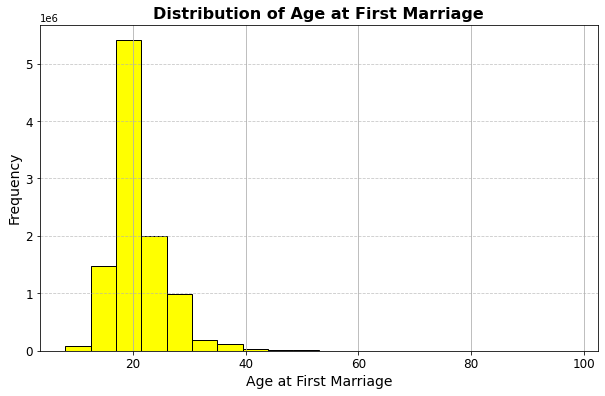

In [16]:
import matplotlib.pyplot as plt

# Creating the histogram
plt.figure(figsize=(10, 6))  # Set the figure size for better clarity
df['age_married'].hist(bins=20, color='yellow', edgecolor='black')  # Customize color and edges

# Adding title and labels with enhanced styling
plt.title('Distribution of Age at First Marriage', fontsize=16, fontweight='bold')
plt.xlabel('Age at First Marriage', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Adjust tick parameters for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Displaying the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add a grid for easier interpretation
plt.show()


## Generate Target Variable for Prediction

In [18]:
# ====================================
# ADD EARLY MARRIAGE VARIABLE
# ====================================
# if age_married < 18, then early_marriage = 1
df['early_marriage'] = df['age_married'].apply(lambda x: 1 if x < EARLY_MARRIAGE_AGE_THRESHOLD else 0)


Proportion of Early Marriages:
early_marriage
0   0.91
1   0.09
Name: proportion, dtype: float64


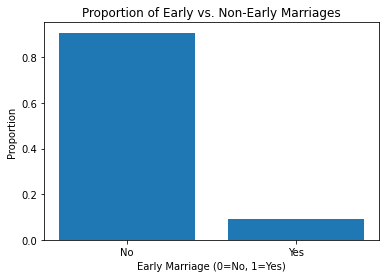

In [21]:
# Early Marriage Prevalence
early_marriage_counts = df['early_marriage'].value_counts(normalize=True)
print("\nProportion of Early Marriages:")
print(early_marriage_counts)
plt.bar(early_marriage_counts.index, early_marriage_counts.values)
plt.title('Proportion of Early vs. Non-Early Marriages')
plt.xlabel('Early Marriage (0=No, 1=Yes)')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

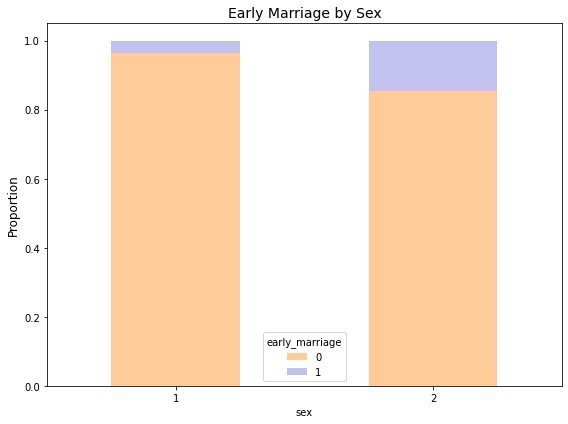

In [22]:
# --- Relationship between early_marriage and sex ---
cross_tab_sex = pd.crosstab(df['early_marriage'], df['sex'], normalize='columns')
plt.figure(figsize=(8, 6))
cross_tab_sex.T.plot(kind='bar', stacked=True, color=['#ffcc99', '#c2c2f0'], ax=plt.gca())
plt.title('Early Marriage by Sex', fontsize=14)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


<ipython-input-23-acff5e98986f>:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot_children, labels=['Not Early Marriage', 'Early Marriage'], patch_artist=True,


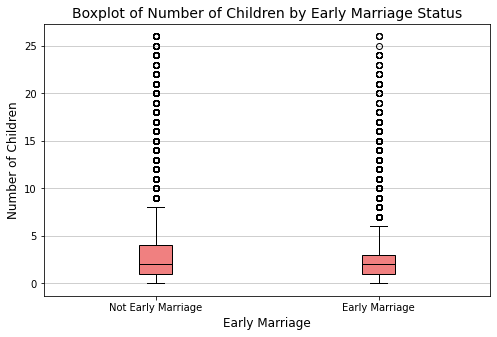

In [23]:
# --- Boxplot of num_children by Early Marriage Status ---
plt.figure(figsize=(8, 5))
data_to_plot_children = [df[df['early_marriage'] == 0]['num_children'], df[df['early_marriage'] == 1]['num_children']]
plt.boxplot(data_to_plot_children, labels=['Not Early Marriage', 'Early Marriage'], patch_artist=True,
           boxprops=dict(facecolor='lightcoral'),
            medianprops=dict(color='black'))
plt.title('Boxplot of Number of Children by Early Marriage Status', fontsize=14)
plt.xlabel('Early Marriage', fontsize=12)
plt.ylabel('Number of Children', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

<ipython-input-24-6fd70a003ff8>:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot_hhsize, labels=['Not Early Marriage', 'Early Marriage'], patch_artist=True,


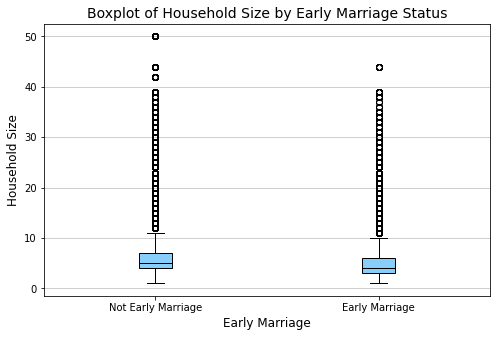

In [24]:
# --- Boxplot of hh_size by Early Marriage Status ---
plt.figure(figsize=(8, 5))
data_to_plot_hhsize = [df[df['early_marriage'] == 0]['hh_size'], df[df['early_marriage'] == 1]['hh_size']]
plt.boxplot(data_to_plot_hhsize, labels=['Not Early Marriage', 'Early Marriage'], patch_artist=True,
            boxprops=dict(facecolor='lightskyblue'),
            medianprops=dict(color='black'))
plt.title('Boxplot of Household Size by Early Marriage Status', fontsize=14)
plt.xlabel('Early Marriage', fontsize=12)
plt.ylabel('Household Size', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [25]:
print(df[['age','age_married', 'hh_size','num_children', 'num_elderly']].describe())
print(df['marital_status'].value_counts())

              age  age_married     hh_size  num_children  num_elderly
count 25673315.00  10341766.00 25674196.00   25674196.00  25674196.00
mean        22.37        20.71        5.42          2.60         0.11
std         17.82         5.03        2.50          1.88         0.37
min          0.00         8.00        1.00          0.00         0.00
25%          8.00        18.00        4.00          1.00         0.00
50%         18.00        20.00        5.00          2.00         0.00
75%         33.00        23.00        7.00          4.00         0.00
max         95.00        98.00       50.00         26.00        15.00
marital_status
2.00    9075215
1.00    6529070
3.00     870705
4.00     568993
Name: count, dtype: int64


# Task-4-Prepare data for ML model building

## Do you think its a good idea to add communes? Please explain your reasoning.

Adding communes as a feature has both potential benefits and drawbacks that I need to consider carefully. On one hand, communes could provide valuable geographic granularity. Communes are smaller administrative units than districts, regions, or provinces, and might capture very specific local factors that influence early marriage, such as cultural norms or community-specific economic conditions. This added detail could potentially allow my model to learn more precise patterns, leading to improved prediction accuracy.

However, on the other hand, including communes could lead to several problems. Firstly, increased dimensionality is a major concern. There are likely to be many unique communes in the dataset. If each commune is one-hot encoded into a separate column, it could create a large number of sparse and potentially less informative features. This increase in dimensionality can lead to overfitting, where the model learns the training data too well but performs poorly on unseen data. Additionally, some communes might have very few observations, reducing the statistical power of those features. Finally, there's the possibility of introducing noise into the model, since some communes may be very similar in characteristics and therefore might not add unique information.

Given the risks of high dimensionality, potential overfitting, and noise, I decided not to include communes as a feature. I believe the geographic information provided by provinces, regions, and districts is sufficient for this analysis and provides a better balance between granularity and model stability.

## Drop Observations
- In this datasets, the marriage variabels are available for all individuals who are 12 years old or older. We can drop the observations where the marriage status is not available.
- Age at first marriage also makes sense for people who are currently married, divorced or widowed.

In [26]:
# Keep only individuals who are 12 years and above
df_marr = df[df['age'] >= 12]

In [27]:
# Keep only individuals who were ever married (currently married, divorced or widowed)
df_marr = df_marr[df_marr['marital_status'] != 1]

## Features for Prediction

In [28]:
def convert2int(x):
    try:
        # Check if value is a float and has no decimal part
        if isinstance(x, float) and x.is_integer():
            return int(x)
        elif isinstance(x, int):  # Handle integers directly
            return x
        else:
            return np.nan  # Return NaN for anything else
    except:
        return np.nan

In [29]:
# ====================================
# PREPARE DATA FOR ML MODELS
# ====================================
numeric_cols = ['age','age_married','years_at_school_level', 'highest_school_level']
for col in numeric_cols:
    df_marr[col] = df_marr[col].apply(convert2int)

# PREPARE DATA FOR ML MODELS
# Target variable for prediction
target_var = 'early_marriage'

# Features to use for prediction
features = [
        'province', 'region', 'district', 'milieu', 'sex',
        'lang_local', 'lang_french', 'lang_english',
        'literacy_local', 'literacy_french', 'literacy_english',
        'hh_relation', 'age', 'marital_status',
        'school_attendance', 'highest_school_level',
        'work_status', 'hh_size','num_children','num_elderly',
        'hoh_age', 'hoh_highest_school_level','hoh_literacy_english',
        'hoh_literacy_french','hoh_literacy_local','hoh_work_status'
        ]


In [30]:
#convert numeric variables to int
numeric_cols = ['age','age_married','years_at_school_level', 'highest_school_level']
for col in numeric_cols:
    df_marr[col] = df_marr[col].apply(convert2int)
    
# Remove rows with NaN values after converting to int
df_marr.dropna(subset=numeric_cols, inplace=True)

In [31]:
# ====================================
# DEAL WITH MISSING VALUES
# ====================================
# Fill missing values with the mode for categorical variables
# and mean/median for continuous variables
for col in features:
    if df_marr[col].dtype == 'object' or df_marr[col].dtype == 'category':
        df_marr[col] = df_marr[col].fillna(df_marr[col].mode()[0])
    else:
        df_marr[col] = df_marr[col].fillna(df_marr[col].median())

In [32]:
# ============================================
# DEAL WITH OUTLIERS IN CONTINUOUS VARIABLES
# =============================================
# Age, drop all observations with age > 100
df_marr = df_marr[df_marr['age'] <= 100]

# HH_SIZE, drop all observations with hh_size > 20
df_marr = df_marr[df_marr['hh_size'] <= 20]

# NUM_CHILDREN, drop all observations with num_children > 1
df_marr = df_marr[df_marr['num_children'] <= 15]

# NUM_ELDERLY, drop all observations with num_elderly > 1
df_marr = df_marr[df_marr['num_elderly'] <= 10]

In [33]:
# ============================================
# ONE-HOT ENCODING FOR CATEGORICAL VARIABLES
# ============================================
df_marr_dummies = pd.get_dummies(df_marr, columns=[col for col in features if df_marr[col].dtype == 'object' or df_marr[col].dtype == 'category'], drop_first=True)
# Convert True/False to 1/0
df_marr_dummies = df_marr_dummies.astype({col: 'int' for col in df_marr_dummies.columns if df_marr_dummies[col].dtype == 'bool'})



In [34]:
# Fill missing values in 'lang_other' and 'literacy_other' with their respective mode
df_marr_dummies['lang_other'].fillna(df_marr_dummies['lang_other'].mode()[0], inplace=True)
df_marr_dummies['literacy_other'].fillna(df_marr_dummies['literacy_other'].mode()[0], inplace=True)

<ipython-input-34-2e4cde7f4c53>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_marr_dummies['lang_other'].fillna(df_marr_dummies['lang_other'].mode()[0], inplace=True)
<ipython-input-34-2e4cde7f4c53>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[

In [35]:
# Verify there are no missing values remaining
print(df_marr_dummies.isnull().sum())

province                    0
region                      0
district                    0
commune                     0
milieu                      0
hh_id                       0
indiv_id                    0
sex                         0
lang_local                  0
lang_french                 0
lang_english                0
lang_other                  0
literacy_local              0
literacy_french             0
literacy_english            0
literacy_other              0
hh_relation                 0
birth_month                 0
birth_year                  0
age                         0
marital_status              0
age_married                 0
school_attendance           0
highest_school_level        0
years_at_school_level       0
work_status                 0
hh_size                     0
num_children                0
num_elderly                 0
hoh_age                     0
hoh_highest_school_level    0
hoh_literacy_english        0
hoh_literacy_french         0
hoh_litera

In [36]:
df_marr_dummies.head()

,province,region,district,commune,milieu,hh_id,indiv_id,sex,lang_local,lang_french,...,hh_size,num_children,num_elderly,hoh_age,hoh_highest_school_level,hoh_literacy_english,hoh_literacy_french,hoh_literacy_local,hoh_work_status,early_marriage
0,1,11,111,11101,1,11101101380021139023530353,1110110138002113903530235301,1,1.00,1.00,...,5,2.00,0.00,35.00,5.00,1.00,1.00,1.00,1.00,0
6,1,11,111,11101,1,11101101370011134020330033,1110110137001113400330203302,2,1.00,1.00,...,9,2.00,1.00,64.00,5.00,2.00,1.00,1.00,1.00,0
13,1,11,111,11101,1,11101101080051077022650265,1110110108005017702650226502,2,1.00,2.00,...,4,1.00,0.00,56.00,3.00,1.00,1.00,1.00,1.00,0
14,1,11,111,11101,1,11101101120021091021930193,1110110112002019101930219301,1,1.00,1.00,...,3,1.00,0.00,25.00,3.00,2.00,1.00,1.00,1.00,0
16,1,11,111,11101,1,11101101170011109022240224,1110110117001110902240222401,2,1.00,1.00,...,5,2.00,0.00,35.00,3.00,1.00,1.00,1.00,1.00,0


In [37]:
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [38]:
def random_forest_with_sklearn(df, num_estimators=100):
    # Define features and target
    X = df_marr_dummies.drop(columns=['early_marriage'])  # Features
    y = df_marr_dummies['early_marriage']  # Target


    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Normalize the data
    normalizer = Normalizer(norm='l2')
    X_train_scaled = normalizer.fit_transform(X_train)
    X_test_scaled = normalizer.transform(X_test)


    # Initialize the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=num_estimators, random_state=42, n_jobs=-1)

    # Train the model
    rf_model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test_scaled)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)

    return rf_model

In [39]:
def evaluate_models_sklearn(df):
    # Define the target variable and features
    # Define features and target
    X = df_marr_dummies.drop(columns=['early_marriage'])  # Features
    y = df_marr_dummies['early_marriage']  # Target


    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Normalize the data
    normalizer = Normalizer(norm='l2')
    X_train_scaled = normalizer.fit_transform(X_train)
    X_test_scaled = normalizer.transform(X_test)


    # Initialize the models
    models = {
        "Logistic Regression": LR(max_iter=1000, random_state=42),
        "Random Forest": RF(n_estimators=100, random_state=42, n_jobs=-1),
        "Gradient Boosting": GBM(n_estimators=100, random_state=42),
        "Extra Trees": ETC(n_estimators=100, random_state=42, n_jobs=-1)
    }

    # Train and evaluate each model
    results = []
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        results.append([name, accuracy])

    # Print the results in a tabular format
    print(tabulate(results, headers=["Model", "Accuracy"], tablefmt="pretty"))

In [40]:
# Build and evaluate the models using the df_marr2_dummies DataFrame
print("Results with sklearn")
evaluate_models_sklearn(df_marr_dummies)


Results with sklearn
+---------------------+--------------------+
|        Model        |      Accuracy      |
+---------------------+--------------------+
| Logistic Regression | 0.8067490749147995 |
|    Random Forest    | 0.8067490749147995 |
|  Gradient Boosting  | 0.8067490749147995 |
|     Extra Trees     | 0.8067490749147995 |
+---------------------+--------------------+


In [71]:
def evaluate_models_spark(df, target_var):
    """
    Evaluate multiple machine learning models using Spark MLlib on the given DataFrame,
    with added normalization step.

    Parameters:
    ----------
    df : pyspark.sql.DataFrame
        The input DataFrame containing features and the target variable.
    target_var : str
        The name of the target variable column.

    Returns:
    -------
    None
    """
    from pyspark.ml.feature import VectorAssembler, Normalizer
    from pyspark.ml.classification import (
        LogisticRegression,
        RandomForestClassifier,
        GBTClassifier,
        DecisionTreeClassifier,
    )
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator

    # Define the features
    features = [col for col in df.columns if col != target_var]

    # Assemble features into a single vector
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    assembled_df = assembler.transform(df)

    # Normalize the features
    normalizer = Normalizer().setP(2).setInputCol("features").setOutputCol("features_normalized")
    normalized_df = normalizer.transform(assembled_df)

    # Select only the normalized features and the target variable
    df = normalized_df.select("features_normalized", target_var).withColumnRenamed("features_normalized", "features")

    # Split the data into training and testing sets
    train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

    # Initialize models
    models = {
        "Logistic Regression": LogisticRegression(maxIter=50).setFeaturesCol("features").setLabelCol(target_var),
        "Random Forest": RandomForestClassifier(numTrees=100, seed=42).setFeaturesCol("features").setLabelCol(target_var),
        "Gradient Boosting": GBTClassifier(maxIter=100, seed=42).setFeaturesCol("features").setLabelCol(target_var),
        "Decision Tree": DecisionTreeClassifier(seed=42).setFeaturesCol("features").setLabelCol(target_var),
    }

    # Initialize evaluator
    evaluator = MulticlassClassificationEvaluator(labelCol=target_var, predictionCol="prediction", metricName="accuracy")

    # Train and evaluate each model
    results = []
    for name, model in models.items():
        # Train the model
        trained_model = model.fit(train_df)

        # Make predictions
        predictions = trained_model.transform(test_df)

        # Evaluate accuracy
        accuracy = evaluator.evaluate(predictions)

        # Append results
        results.append([name, accuracy])

    # Print results in a tabular format
    from tabulate import tabulate
    print(tabulate(results, headers=["Model", "Accuracy"], tablefmt="pretty"))


In [42]:
sdf_marr = spark.createDataFrame(df_marr_dummies)

In [45]:
# Drop hh_id and indiv_id from sdf_marr
sdf_marr = sdf_marr.drop('hh_id', 'indiv_id')

In [ ]:
print("Results with spark")
evaluate_models_spark(sdf_marr,"early_marriage")

In [ ]:

# Top factors from the best model (Gradient Boosting)
# Scikit-learn
target_var = 'early_marriage'
features = df_marr_dummies.columns[df_marr_dummies.columns != target_var]

X = df_marr_dummies[features]
y = df_marr_dummies[target_var]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

gbm_model = GBM(n_estimators=100, random_state=42)
gbm_model.fit(X_train, y_train)
feature_importance = pd.DataFrame({'feature':features,'importance':gbm_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print(f"Top five factors (using Gradient Boosting):")
print(feature_importance.head(5))